<a href="https://colab.research.google.com/github/fatimakhazaeni/_my_Deep_Nets_repo/blob/main/Mask_R_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Mask R-CNN**

#Connect Google Drive

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

#!ls 'drive/My Drive'

Mounted at /content/drive


In [ ]:
import numpy as np
from keras.preprocessing import image
import torchvision
import cv2
import torch
from torchvision.transforms import v2
import random
import matplotlib.pyplot as plt

یک مدل از قبل آموزش دیده Resnet50 Faster R-CNN با وزن های آموزش دیده را دانلود می کند.

In [ ]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:01<00:00, 139MB/s]


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

نام کلاس های ارائه شده

In [ ]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]



برای گرفتن مسیر تصویر و پیش بینی تصویر توسط مدل ، یک تابع  تعریف کنیم.
تصویر از مسیر داده شده بدست می آید

تصویر با استفاده از تبدیلات PyTorch به تنسور تصویر تبدیل می شود

تصویر برای بدست آوردن پیش بینی ها وارد مدل ما می شود

کلاس و مختصات کادر بدست می آید، اما فقط امتیاز پیش بینی های بزرگ تر از آستانه انتخاب می شود.

ماسک ها ، کلاس های پیش بینی و مختصات کادر محصورکننده از مدل بدست می آیند و ماسک های باینری ساخته می شوند (۰ یا ۱). مثال : ناحیه گربه ۱ و بقیه تصویر ۰ هستند.


In [ ]:
def get_prediction(img_path, threshold):
  #img = Image.open(img_path)
  img = cv2.imread(img_path)
  transform = v2.Compose([v2.ToTensor()])
  img = transform(img)
  pred = model([img])
  pred_score = list(pred[0]['scores'].detach().numpy())
  pred_t = [pred_score.index(x) for x in pred_score if x>threshold][-1]
  masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()
  pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())]
  pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())]
  masks = masks[:pred_t+1]
  pred_boxes = pred_boxes[:pred_t+1]
  pred_class = pred_class[:pred_t+1]
  return masks, pred_boxes, pred_class

به ماسک هر شی پیش بینی شده ، از بین ۱۱ رنگ تعیین شده ، یک رنگ تصادفی اختصاص داده می شود.

In [ ]:
def random_colour_masks(image):
  colours = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180],[250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]
  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  r[image == 1], g[image == 1], b[image == 1] = colours[random.randrange(0,10)]
  coloured_mask = np.stack([r, g, b], axis=2)
  return coloured_mask

ماسک ها ، کلاس پیش بینی و کادر محصورکننده با get_prediction بدست می آیند.

به هر ماسک یک رنگ تصادفی از بین ۱۱ رنگ اختصاص داده می شود.

هر ماسک در نسبت ۱:۰٫۵ با OpenCV به تصویر اضافه می شود

یک کادر محصورکننده با rektangle با نام کلاس که به صورت حاشیه نویسی متنی روی آن رسم شده است.

خروجی نهایی نمایش داده می شود

In [ ]:
def instance_segmentation_api(img_path, threshold=0.5, rect_th=3, text_size=3, text_th=3):
  masks, boxes, pred_cls = get_prediction(img_path, threshold)
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  for i in range(len(masks)):
    rgb_mask = random_colour_masks(masks[i])
    img = cv2.addWeighted(img, 1, rgb_mask, 0.5, 0)

    x1y1 = tuple((np.array(boxes[i][0]) ).astype(np.int32))
    x2y2 = tuple((np.array(boxes[i][1]) ).astype(np.int32))

    cv2.rectangle(img, x1y1, x2y2, color=(0, 255, 0), thickness=rect_th)
    cv2.putText(img,pred_cls[i], x1y1, cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th)
  plt.figure(figsize=(20,30))
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])
  plt.show()

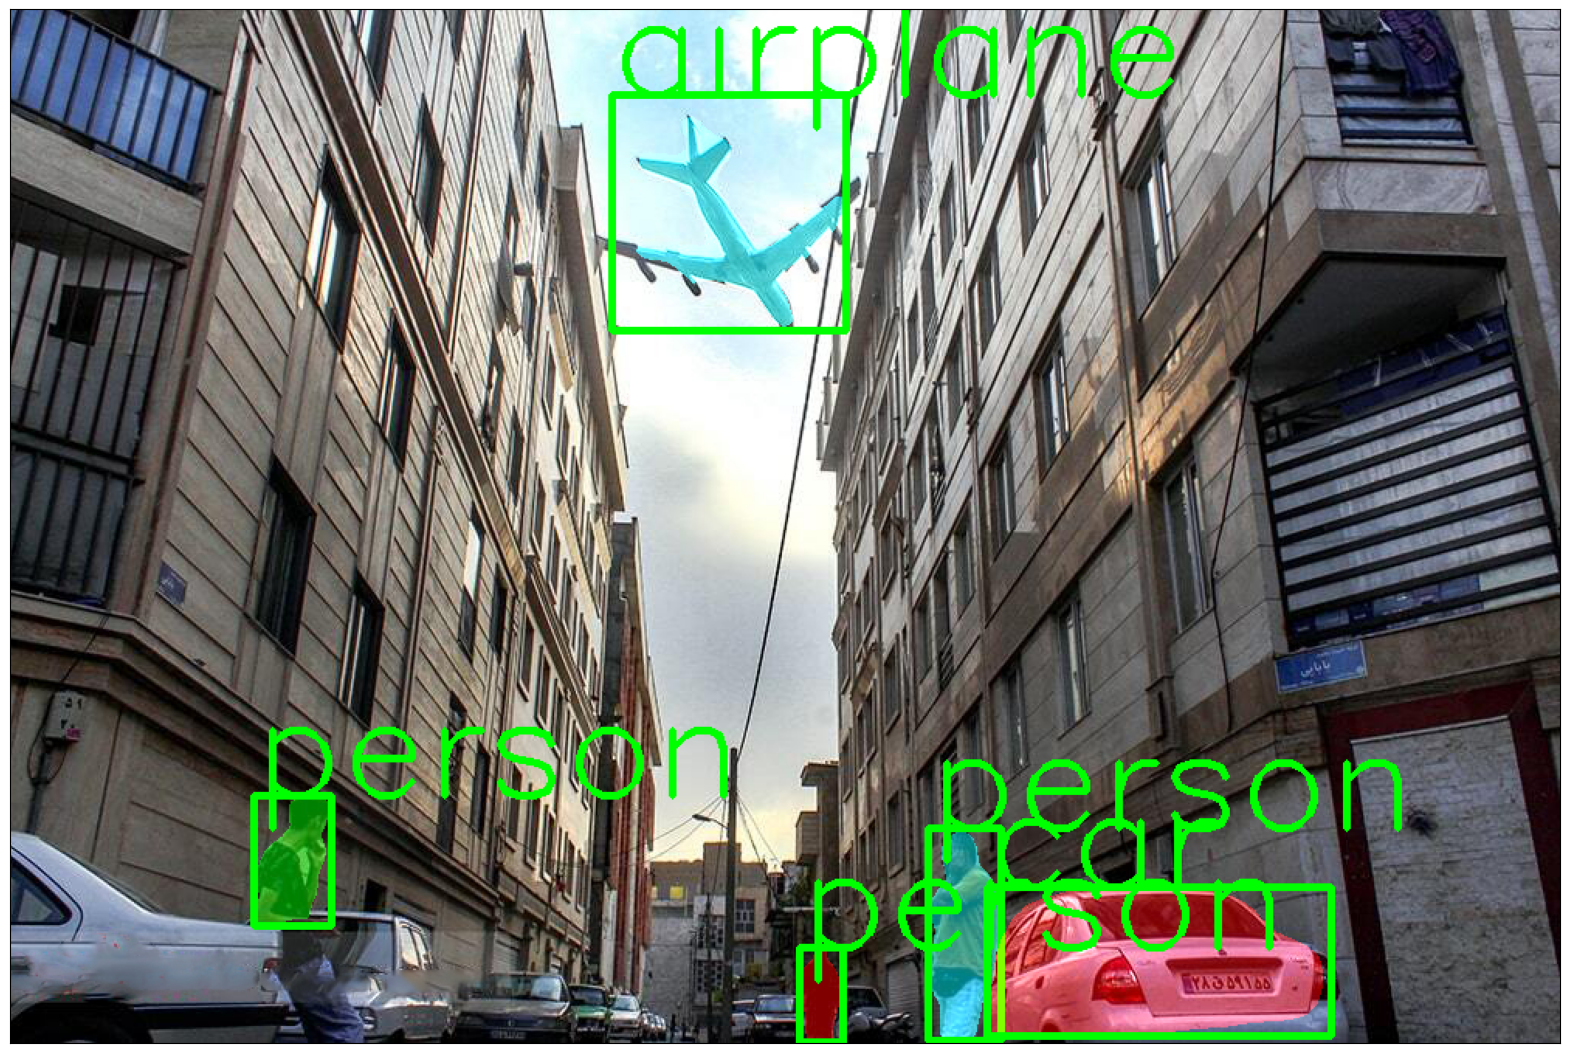

In [ ]:
instance_segmentation_api('/content/drive/MyDrive/HomeWork deep learning/5/Detection/1647353_372.jpg', threshold=0.8)

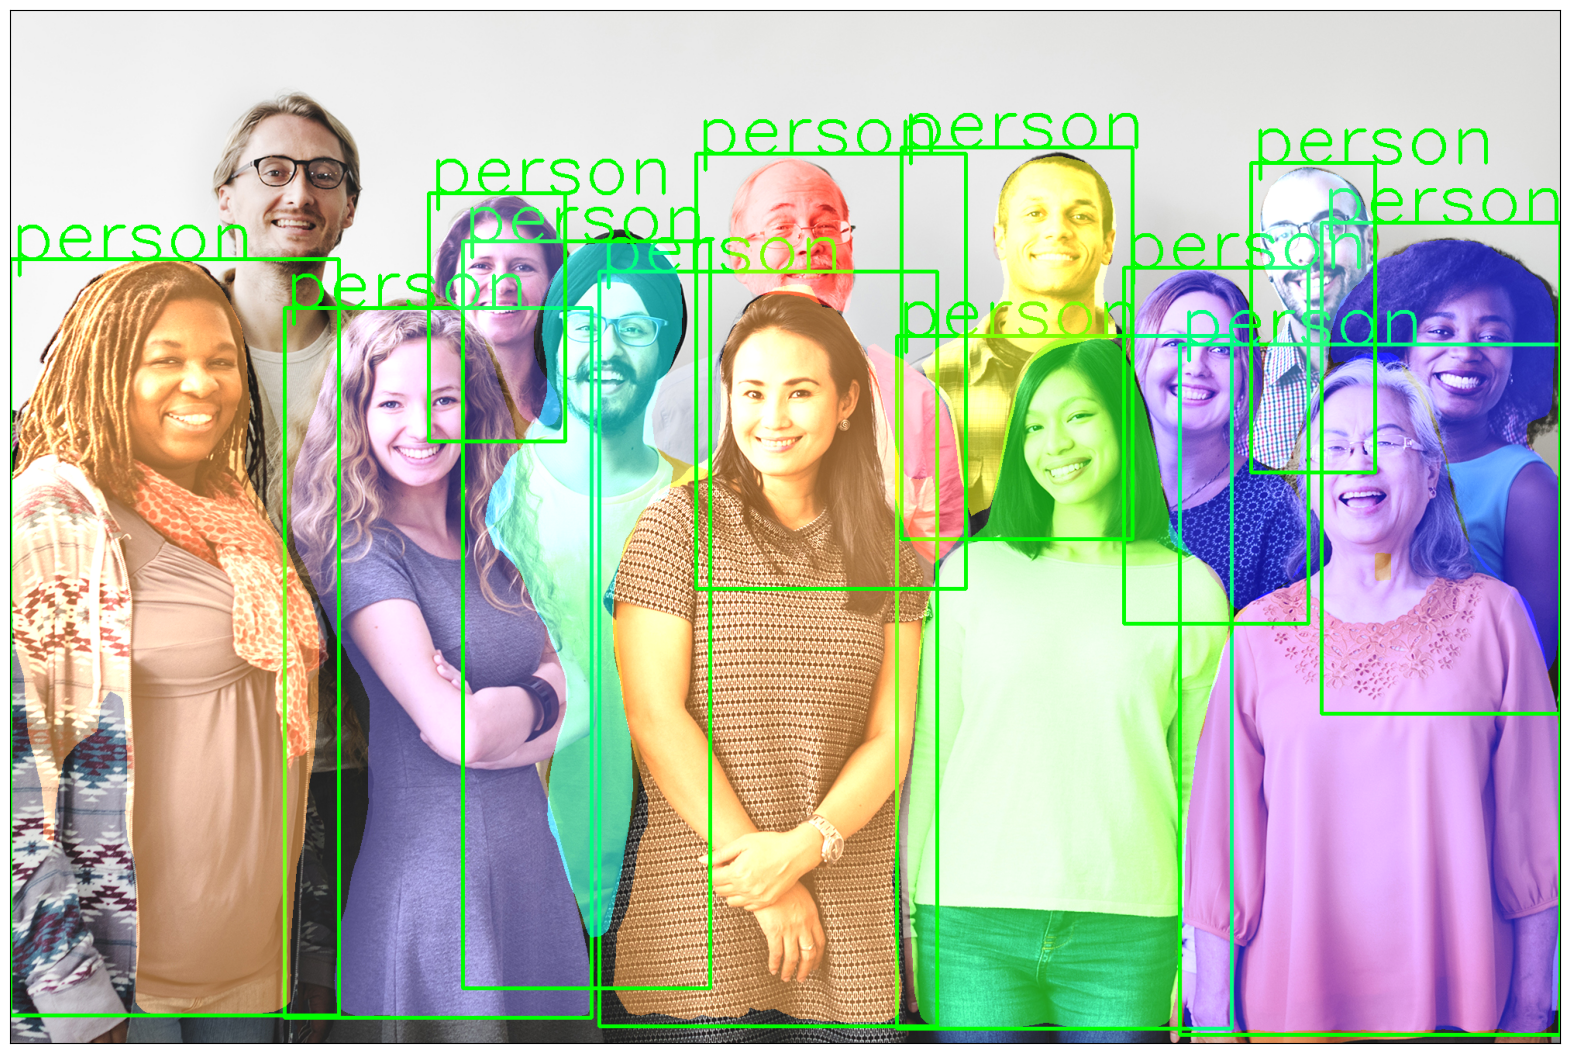

In [ ]:
instance_segmentation_api('/content/drive/MyDrive/HomeWork deep learning/5/Detection/banner-diverse-group-of-people-2.jpg', threshold=0.8)